    Copyright (C) 2015 Jingkun Gao (jingkun@cmu.edu)
    
    This file is part of PLAID code repo.
    
    This program is free software: you can redistribute it and/or modify
    it under the terms of the GNU General Public License as published by
    the Free Software Foundation, either version 3 of the License, or
    (at your option) any later version.

    This program is distributed in the hope that it will be useful,
    but WITHOUT ANY WARRANTY; without even the implied warranty of
    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
    GNU General Public License for more details.

    You should have received a copy of the GNU General Public License
    along with this program.  If not, see <http://www.gnu.org/licenses/>

In this IPython Notebook, I will show how to load data and extract features from PLAID. Meanwhile, I will test the performance of appliance identification using PLAID.

<span style="color:red">Please make sure Python3 and other necessary packages (using pip3 to install <b>*ipython, jinja2, jsonschema, matplotlib, numpy, scipy, pyzmq, pygments, tornado, scikit-learn*</b>) are installed,</span>

In [1]:
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime

import matplotlib as mpl
import matplotlib.font_manager as fm

%matplotlib inline

In [2]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',
                delimiter=',',names='current,voltage',dtype=(float,float))
            else:
                p = subprocess.Popen(['tail','-'+str(int(last_offset)),
                   path+str(ist_id)+'.csv'],stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',
                        names='current,voltage',dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'
            %(n,n,100,'%',(datetime.now()-start).seconds)) 
        return data


def clean_meta(ist):
    '''remove None elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M


In [3]:
# read meta
Data_path = 'PLAID/'
csv_path = Data_path + 'CSV/';

import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)

    
Meta = parse_meta([meta1])
meta1 = parse_meta([meta1])

In [4]:
# read data
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
IDs_for_read_data = list(Meta.keys())
# households of appliances
Locs = [x['header']['collection_time']+'_'+x['location'] for x in Meta.values()]
# unique households
Unq_loc = list(set(Locs))
Unq_loc.sort()

In [5]:
print('Number of households: %d\nNumber of total measurements:%d'%(len(Unq_loc),len(Locs)))

Number of households: 55
Number of total measurements:1074


In [6]:
# read data, we take steady states from last 10000 points
# estimated time cost:  ~ 1 mins
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True,last_offset=npts)

108/1074 (10%) have been read...	 time consumed: 7s
216/1074 (20%) have been read...	 time consumed: 13s
324/1074 (30%) have been read...	 time consumed: 18s
432/1074 (40%) have been read...	 time consumed: 23s
540/1074 (50%) have been read...	 time consumed: 28s
648/1074 (60%) have been read...	 time consumed: 34s
756/1074 (70%) have been read...	 time consumed: 40s
864/1074 (80%) have been read...	 time consumed: 48s
972/1074 (91%) have been read...	 time consumed: 54s
1074/1074 (100%) have been read(Done!) 	 time consumed: 58s


In [7]:
print('Total number of instances:%d'%len(Data))

Total number of instances:1074


We start by extracting one representative period of steady state for each instance.

In [8]:
fs = 30000
f0 = 60
NS = fs/f0 # number of samples per period
NP = npts/NS # number of periods for npts

# calculate the representative one period of steady state 
# (mean of the aggregated signals over one cycle)
n = len(Data)
rep_I = np.empty([n,NS])
rep_V = np.empty([n,NS])
for i in range(n):
    tempI = np.sum(np.reshape(Data[i+1]['current'],[NP,NS]),0)/NP
    tempV = np.sum(np.reshape(Data[i+1]['voltage'],[NP,NS]),0)/NP
    # align current to make all samples start from 0 and goes up
    ix = np.argsort(np.abs(tempI))
    j = 0
    while True:
        if ix[j]<499 and tempI[ix[j]+1]>tempI[ix[j]]:
            real_ix = ix[j]
            break
        else:
            j += 1
    rep_I[i,] = np.hstack([tempI[real_ix:],tempI[:real_ix]])
    rep_V[i,] = np.hstack([tempV[real_ix:],tempV[:real_ix]])

Extract labels for appliance type and locations(used for train/test split).

In [9]:
type_Ids = {}
loc_Ids = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii+1
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 11
number of different households: 55


We then look at the distributions of appliance types and locations.

['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine']


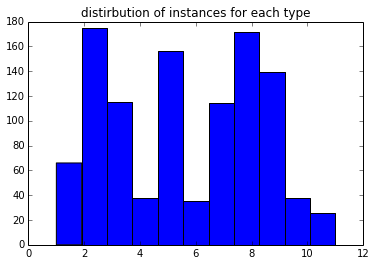

In [10]:
plt.hist(type_label,len(Unq_type))
plt.title('distirbution of instances for each type')
print(Unq_type)


We can see that we have an unbalanced dataset, more instances for CFL, Hairdryer, Laptop and less for Fridge, Heater, Vacuum and Washing Machine.

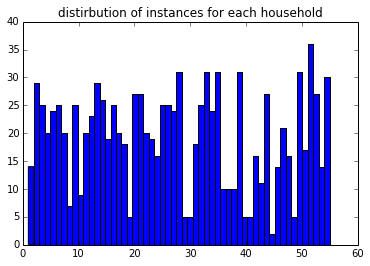

In [11]:
plt.hist(loc_label,len(Unq_loc))
plt.title('distirbution of instances for each household')

Next, we have rep_I, rep_V, type_label, loc_label. We will start from here to extract features and evalute classification performance. To begin, we first write a function for classifiers.

# Classifiers 

In [12]:
import sklearn
from sklearn import cross_validation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

def myclassifiers(X_train,y_train,X_test,y_test,verbose=False):
    
    knn = KNeighborsClassifier(n_neighbors=1)
    gnb = GaussianNB()
    logistic = LogisticRegression(C=1e5)
    svc = svm.SVC(kernel='rbf',gamma=.7,C=1.0)
    lda = LDA(solver='lsqr', shrinkage='auto')
    qda = QDA()
    dTree = tree.DecisionTreeClassifier(max_depth=10)
    rForest = RandomForestClassifier(max_depth=10,n_estimators=20)
    adaBoost = AdaBoostClassifier()
    
    names = ["Nearest Neighbors(k=1)", "Naive Bayes","Logistic","RBF SVM",
             "LDA", "QDA","Decision Tree","Random Forest", "AdaBoost"]
    classifiers = [knn, gnb, logistic, svc, lda, qda, dTree, rForest, adaBoost]
    y_predict = []
    acc = []
#     print('Running',end="")
    for (i,clf) in enumerate(classifiers):
        if verbose:
            print(' %s... '% names[i],end="")
        clf.fit(X_train,y_train)
        y_predict.append(clf.predict(X_test))
        acc.append(clf.score(X_test,y_test))
    return (acc,y_predict,names)

In [13]:
# test classifiers
X_train, X_test, y_train, y_test = cross_validation.train_test_split(
    rep_I[:,:10], type_label, test_size=0.1, random_state=0)
(acc,y_p,names) = myclassifiers(X_train,y_train,X_test,y_test)

In [14]:
acc

[0.62037037037037035,
 0.46296296296296297,
 0.40740740740740738,
 0.32407407407407407,
 0.046296296296296294,
 0.46296296296296297,
 0.58333333333333337,
 0.65740740740740744,
 0.19444444444444445]

# Features

## 1. Raw Current 
**RawCF**

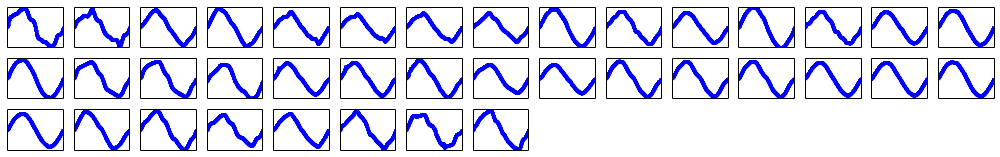

In [15]:
RawCF = rep_I
# visualization of current features from certain type in RawCF
type_id = 4
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.plot(RawCF[i,],'.')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()  

## 2. Real/Reactive Power, PQ Plane feature
**PQ**: Calculate real and reactive power from steady states

In [16]:
n = len(Data)
PQ = np.empty([n,2])
PQ[:,0] = np.mean(rep_I*rep_V,1) # real power
for i in range(n):
    tempI = Data[i+1]['current'][NS+1:]
    tempV = Data[i+1]['voltage'][NS-NS/4+1:-NS/4]
    PQ[i,1] = np.sum(tempI*tempV)/(npts-NS) # reactive power

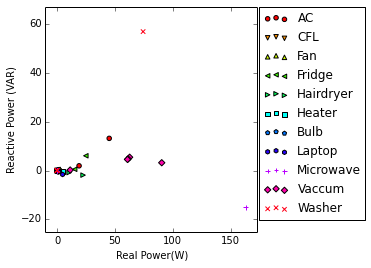

In [17]:
import matplotlib.cm as cmx
import matplotlib.colors as colors

def get_cmap(N):
    '''Returns a function that maps each index in 0, 1, ... N-1
     to a distinct RGB color. Courtesy to the code snipped from
     http://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib'''
    color_norm  = colors.Normalize(vmin=0, vmax=N-1)
    scalar_map = cmx.ScalarMappable(norm=color_norm, cmap='hsv') 
    def map_index_to_rgb_color(index):
        return scalar_map.to_rgba(index)
    return map_index_to_rgb_color 

cmap = get_cmap(11)
Legends=('AC','CFL','Fan','Fridge','Hairdryer','Heater',
         'Bulb','Laptop','Microwave','Vaccum','Washer')
markers='ov^<>sph+Dx'
colors='bgrcmk'
minx,maxx,miny,maxy = (0,0,0,0)
fig=plt.figure(figsize=(4.9,3.9))
ax=fig.add_subplot(1,1,1)
ax.set_position([0.1,0.1,.6,0.8])
# visualization of current features from certain type in PQ
for i in range(11):
    ix=np.where(type_label==i+1)[0]
    b = np.random.randint(len(ix),size=5)
    ix1 = ix[b]
    tempx = PQ[ix1,0]
    tempy = PQ[ix1,1]
    plt.scatter(tempx,tempy,c=cmap(i),marker=markers[i],label=Legends[i])
    minx = min(minx,min(tempx))
    maxx = max(maxx,max(tempx))
    miny = min(miny,min(tempy))
    maxy = max(maxy,max(tempy))    
plt.axis([minx-10,maxx+10,miny-10,maxy+10])
plt.xlabel('Real Power(W)')
plt.ylabel('Reactive Power (VAR)')
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
# plt.tight_layout()
plt.savefig('PQ.eps', format='eps')

## 3. Harmonics
**HarmonicsF**: We will take up to 21st order of odd number harmonics

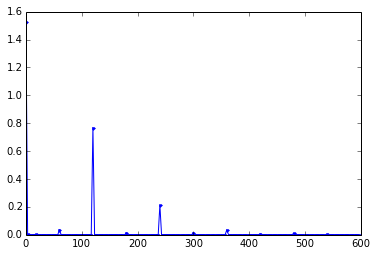

In [18]:
order = 21
p = (order-1)//2+1 # number of harmonics to be extracted
harmonics = np.linspace(1,order,num=p)
fs = 30000
npts = 10000
f0 = 120 # for power

HarmonicsF = np.empty([n,p])
# visualize power harmonics of one instance
ix = 100
temp_P = Data[ix]['current']*Data[ix]['voltage']
x = np.linspace(0,fs,num=npts)
y = np.abs(np.fft.fft(temp_P))
plt.plot(x[:200],y[:200],'.-')

In [19]:
for i in range(n):
    temp_P = Data[i+1]['current']*Data[i+1]['voltage']
    y = np.abs(np.fft.fft(temp_P))
    h = 40*harmonics+1
    h = h.astype(int)
    HarmonicsF[i,] =y[h]
HarmonicsF[1,]

array([ 243.64503882,  193.70306001,  117.70885748,  214.43577532,
        159.33701771,  142.63784478,  187.11448239,  181.24640381,
        128.33473084,   78.64050177,  118.07826993])

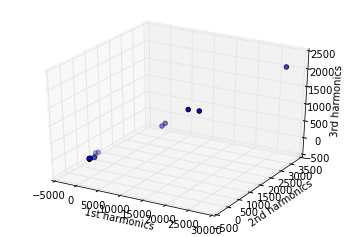

In [20]:
# visualization of harmonics features from certain type
from mpl_toolkits.mplot3d import Axes3D

ix1=np.where(type_label==9)[0][:20]
ix2=np.where(type_label==7)[0][:20]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=HarmonicsF[ix1,0], ys=HarmonicsF[ix1,1], 
           zs=HarmonicsF[ix1,2],c='b')
ax.scatter(HarmonicsF[ix2,0], HarmonicsF[ix2,1], 
           zs=HarmonicsF[ix2,2],c='r')
ax.set_xlabel('1st harmonics')
ax.set_ylabel('2nd harmonics')
ax.set_zlabel('3rd harmonics')

plt.show()

## 4. Quantized current/voltage
**BinF** : This feature is similar to downsample the data. 

In [21]:
num = 20 # number of bins

def get_BinF(X,num):
    '''X should be nd array of size N*P, the output will be N*num'''
    (N,P) = X.shape
    newP = np.floor(P/num)*num
    newX = np.reshape(X[:,:newP],[N,num,newP/num])
    BinF = np.sum(newX,2)
    return BinF
BinF_I = get_BinF(rep_I,num)    
BinF_V = get_BinF(rep_V,num)    

In [22]:
BinF = np.hstack([BinF_I,BinF_V])

In [23]:
BinF.shape

(1074, 40)

In [24]:
Unq_type

['Air Conditioner',
 'Compact Fluorescent Lamp',
 'Fan',
 'Fridge',
 'Hairdryer',
 'Heater',
 'Incandescent Light Bulb',
 'Laptop',
 'Microwave',
 'Vacuum',
 'Washing Machine']

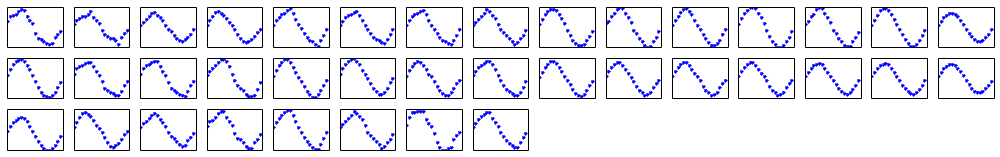

In [25]:
# visualization of all Bin current features from certain type in BinF
type_id = 4
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.plot(BinF_I[i,],'.')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()  

## 5. VI binary image
**BinaryF**: Raw 0/1 binary VI images

In [26]:
from scipy import signal

def center(X,w):
    minX = np.amin(X)
    maxX = np.amax(X)
    dist = max(abs(minX),maxX)
    X[X<-dist] = -dist
    X[X>dist] = dist
    d = (maxX-minX)/(w-1)
    return (X,d)
    
def get_img_from_VI(V, I, width,hard_threshold=False,para=.5):
    '''Get images from VI, hard_threshold, set para as threshold to cut off,5-10
    soft_threshold, set para to .1-.5 to shrink the intensity'''
    # center the current and voltage, get the size resolution of mesh given width
    d = V.shape[0]
    # doing interploation if number of points is less than width*2
    if d<2* width:
        newI = np.hstack([V, V[0]])
        newV = np.hstack([I, I[0]])
        oldt = np.linspace(0,d,d+1)
        newt = np.linspace(0,d,2*width)
        I = np.interp(newt,oldt,newI)
        V = np.interp(newt,oldt,newV)
        
    (I,d_c)  = center(I,width)
    (V,d_v)  = center(V,width)
    
    #  find the index where the VI goes through in current-voltage axis
    ind_c = np.floor((I-np.amin(I))/d_c)
    ind_v = np.floor((V-np.amin(V))/d_v)
    ind_c[ind_c==width] = width-1
    ind_v[ind_v==width] = width-1
    
    Img = np.zeros((width,width))
    
    for i in range(len(I)):
        Img[ind_c[i],width-ind_v[i]-1] += 1
    
    if hard_threshold:
        Img[Img<para] = 0
        Img[Img!=0] = 1
        return Img
    else:
        return (Img/np.max(Img))**para
    

In [27]:
n = len(Data)
width = 16

Imgs = np.empty((n,width,width), dtype=np.float64)
for i in range(n):
    Imgs[i,:,:] = get_img_from_VI(rep_V[i,], rep_I[i,], width,True,1)
BinaryF=np.reshape(Imgs,(n,width*width))

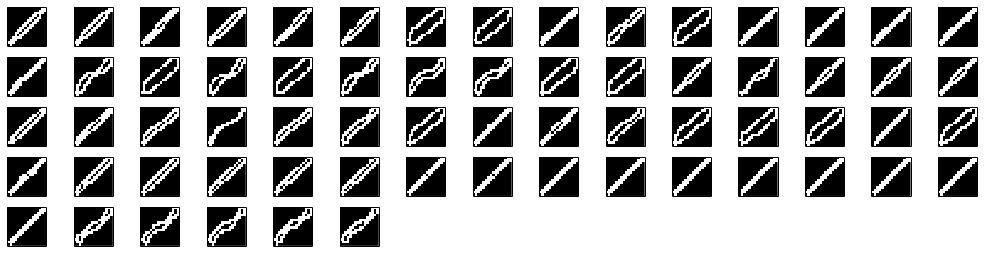

In [28]:
# visualization of all imgaes from certain type in Imgs
type_id = 1
n = sum(type_label==type_id)
fig = plt.figure(figsize=(14,np.ceil(n/15)))
count = 1
for i in np.where(type_label==type_id)[0]:
    plt.subplot(np.ceil(n/10),15,count)
    plt.imshow(Imgs[i,:,:],cmap = cm.Greys_r,interpolation='None')
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
#     plt.title('Id: '+str(k),fontsize=10)
    count += 1
fig.tight_layout()
plt.show()  

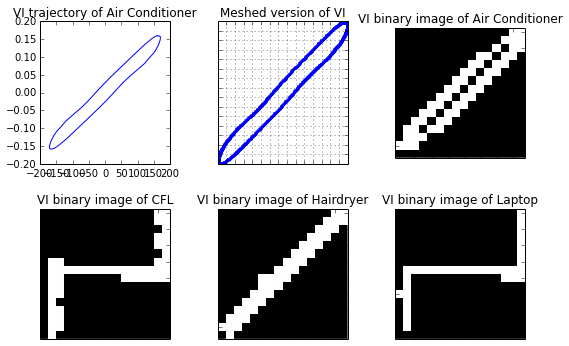

In [29]:
# AC-1,CFL-2,hairdryer-5,laptop-8
ix=np.where(type_label==1)[0][30]
fig=plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(2,3,1)
plt.plot(rep_V[ix,:],rep_I[ix,:])
plt.title('VI trajectory of Air Conditioner')
# plt.xlabel('Voltage')
# plt.ylabel('Current')

ax = fig.add_subplot(2,3,2)
plt.plot(rep_V[ix,:],rep_I[ix,:],'.')
xticks = np.linspace(min(rep_V[ix,:]),max(rep_V[ix,:]),num=16)
yticks = np.linspace(min(rep_I[ix,:]),max(rep_I[ix,:]),num=16)
plt.axis([min(rep_V[ix,:]),max(rep_V[ix,:]),min(rep_I[ix,:]),max(rep_I[ix,:])])
ax.set_xticks(xticks)
ax.set_yticks(yticks)
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
# plt.tick_params(axis='y',which='both',labelbottom='off')
plt.title('Meshed version of VI')
ax.grid(which='both')

ax3 = fig.add_subplot(2,3,3)
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.title('VI binary image of Air Conditioner')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')

ax4 = fig.add_subplot(2,3,4)
ix=np.where(type_label==2)[0][13]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of CFL')


ax5 = fig.add_subplot(2,3,5)
ix=np.where(type_label==5)[0][19]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of Hairdryer')

ax6 = fig.add_subplot(2,3,6)
ix=np.where(type_label==8)[0][13]
plt.imshow(Imgs[ix,:,:],cmap = cm.Greys_r,interpolation='None')
plt.tick_params(axis='both',which='both',labelbottom='off',labelleft='off')
plt.title('VI binary image of Laptop')


plt.tight_layout()
plt.show()
plt.savefig('VI.eps', format='eps')

## 6. PCA on abve three
**PCA_BinF, PCA_BinaryF, PCA_RawCF**: Use projected components which take more than 95% variations as the features

In [30]:
from sklearn.decomposition import PCA

# write a function to extract up to certain percent of projected components
def get_PCs(X,p):
    # X: nd array of size sample_nums*features, 
    # p: percentage of variation to be taken
    pca = PCA(whiten=True)
    pca.fit(X)
    ix=np.where(np.cumsum(pca.explained_variance_ratio_)>p)[0][0]
    pca = PCA(n_components=ix,whiten=True)
    return pca.fit_transform(X)
    

In [31]:
p = .99
PCA_BinF = get_PCs(BinF,p)
PCA_BinaryF = get_PCs(BinaryF,p)
PCA_RawCF = get_PCs(RawCF,p)

In [32]:
np.isnan(np.sum(PCA_BinF))

False

In [33]:
np.isnan(np.sum(PCA_BinaryF))

False

In [34]:
np.isnan(np.sum(PCA_RawCF))

False

# TSNE vs PCA

To visualize the features, we use TSNE and PCA to project them into 2 dimensional space.

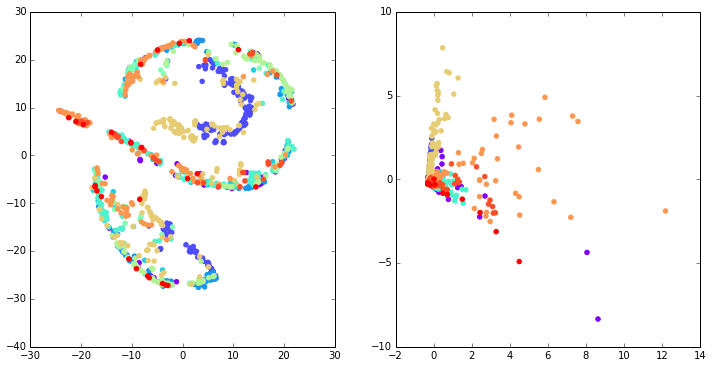

In [35]:
# look at harmonics
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
pca = PCA(n_components=2,whiten=True)
newHar = model.fit_transform(HarmonicsF)

TSNEF = newHar
PCAF = pca.fit_transform(HarmonicsF)
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

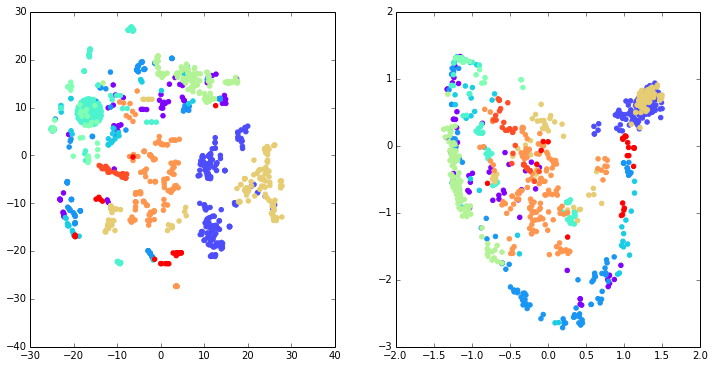

In [36]:
# look at binary images
TSNEF = model.fit_transform(BinaryF)
PCAF = pca.fit_transform(BinaryF)
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

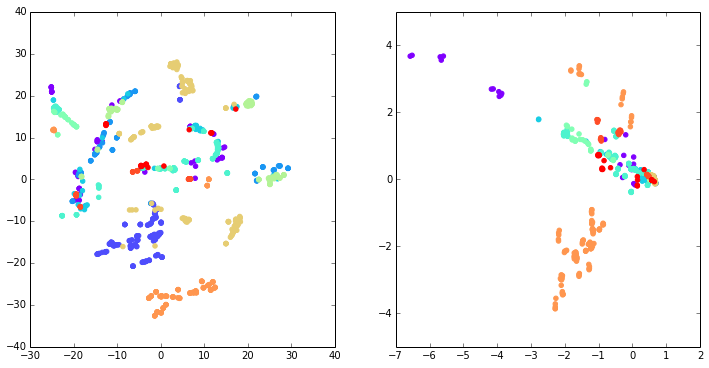

In [37]:
# look at raw current
TSNEF = model.fit_transform(RawCF)
PCAF = pca.fit_transform(RawCF)
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

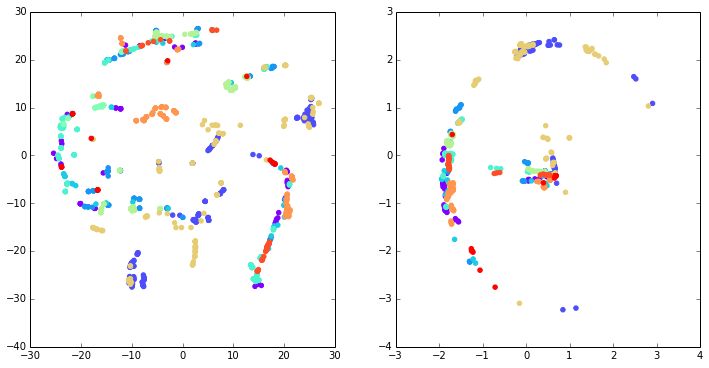

In [38]:
# look at raw current and voltage
TSNEF = model.fit_transform(np.hstack([rep_I,rep_V]))
PCAF = pca.fit_transform(np.hstack([rep_I,rep_V]))
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

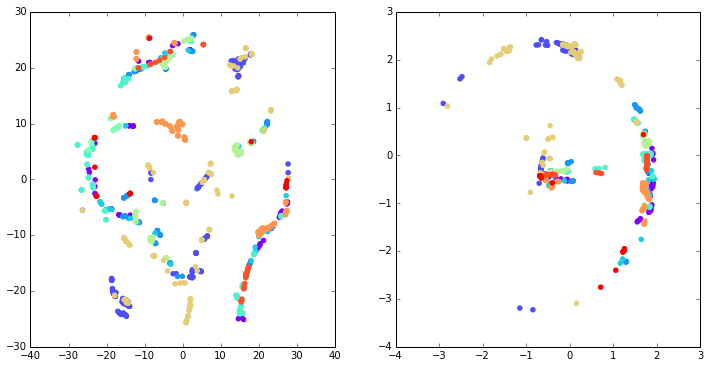

In [39]:
# look at binF
TSNEF = model.fit_transform(BinF)
PCAF = pca.fit_transform(BinF)
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

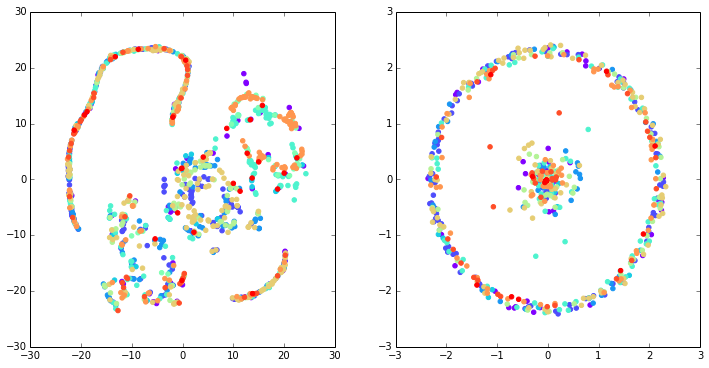

In [40]:
# look at Raw
D=np.array([np.hstack([Data[i+1]['current'],Data[i+1]['voltage']])
            for i in range(1074)])
TSNEF = model.fit_transform(D)
PCAF = pca.fit_transform(D)
colors = cm.rainbow(np.linspace(0, 1, 11))
fig = plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(TSNEF[ix,0], TSNEF[ix,1], color=c)
plt.subplot(1,2,2)
for i, c in zip(range(11), colors):
    ix = np.where(type_label==i+1)[0]
    plt.scatter(PCAF[ix,0], PCAF[ix,1], color=c)

# Evaluation

A reasonable way to evalute the features is to train and test on different appliances, to makes sure the test instances won't show up in the training set, we propose an evaluation strategy. There are 55 households, we train on some households and test on the rest. Here we use leave-one-out cross-validation, where we train on 54 households on test on the rest one household. The process is repeated 55 times and the mean accuracy is reported.

In [41]:
# We orgainze the variables to be used
F = [RawCF, PQ, HarmonicsF,BinF, BinaryF, PCA_RawCF, PCA_BinF, PCA_BinaryF]
namesF = [ 'Raw Current','PQ','Harmonics','Quantized Current/Voltage', 
          'Binary Images', 'PCA on Current', 
          'PCA on Bin Current/Voltage','PCA on Binary Images']
print('type label:',type_label)
print('location label:', loc_label)
print('number of different types: %d\n'% len(Unq_type),Unq_type)
print('number of different households: %d\b'% len(Unq_loc))

type label: [ 2  2  2 ...,  8  8 11]
location label: [ 1  1  1 ..., 51 51 51]
number of different types: 11
 ['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge', 'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop', 'Microwave', 'Vacuum', 'Washing Machine']
number of different households: 55


In [42]:
for f in F:
    print(f.shape)

(1074, 500)
(1074, 2)
(1074, 11)
(1074, 40)
(1074, 256)
(1074, 3)
(1074, 1)
(1074, 112)


In [43]:
start = datetime.now()
n = len(Unq_loc)
num_clf = 9
num_f = len(F)
acc = np.empty([num_f,num_clf])
predictedY = [[np.empty([0],dtype='int')]*num_clf]*num_f
trueY = np.empty([0],dtype='int')
# loop over each household
for i in range(n):   
    print('%d/%d fold...\t time consumed: %ds'%(i+1,n,
                        (datetime.now()-start).seconds))
    # split data into X_train,y_train,X_test,y_test based on households
    ix_test = np.where(loc_label==i+1)[0]
    ix_train = np.where(loc_label!=i+1)[0]
    temp_acc = np.empty([num_f,num_clf])
    # loop over each feature
    for (j,f) in enumerate(F):
        X_test = f[ix_test]
        y_test = type_label[ix_test]
        X_train = f[ix_train]
        y_train = type_label[ix_train]
        
        (temp,y_p,clf_names) = myclassifiers(X_train,
                                y_train,X_test,y_test) 
        temp_acc[j] = np.array(temp)
        predictedY[j] = [np.hstack([predictedY[j][ii],
                        y_p[ii]]) for ii in range(num_clf)]
    trueY = np.hstack([trueY,y_test])
    acc += temp_acc

1/55 fold...	 time consumed: 0s
2/55 fold...	 time consumed: 16s
3/55 fold...	 time consumed: 33s
4/55 fold...	 time consumed: 50s
5/55 fold...	 time consumed: 67s
6/55 fold...	 time consumed: 84s
7/55 fold...	 time consumed: 101s
8/55 fold...	 time consumed: 118s
9/55 fold...	 time consumed: 135s
10/55 fold...	 time consumed: 151s
11/55 fold...	 time consumed: 168s
12/55 fold...	 time consumed: 185s
13/55 fold...	 time consumed: 202s
14/55 fold...	 time consumed: 219s
15/55 fold...	 time consumed: 235s
16/55 fold...	 time consumed: 252s
17/55 fold...	 time consumed: 269s
18/55 fold...	 time consumed: 286s
19/55 fold...	 time consumed: 303s
20/55 fold...	 time consumed: 320s
21/55 fold...	 time consumed: 337s
22/55 fold...	 time consumed: 353s
23/55 fold...	 time consumed: 370s
24/55 fold...	 time consumed: 387s
25/55 fold...	 time consumed: 403s
26/55 fold...	 time consumed: 420s
27/55 fold...	 time consumed: 436s
28/55 fold...	 time consumed: 453s
29/55 fold...	 time consumed: 470s
3

/usr/local/lib/python3.4/dist-packages/sklearn/qda.py:133: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [44]:
real_acc_table = np.array([[accuracy_score(trueY, i) for i in j] for j in predictedY])

In [45]:
np.set_printoptions(precision=4)
print(clf_names)
print(real_acc_table)
print(namesF)

['Nearest Neighbors(k=1)', 'Naive Bayes', 'Logistic', 'RBF SVM', 'LDA', 'QDA', 'Decision Tree', 'Random Forest', 'AdaBoost']
[[ 0.7598  0.6173  0.6983  0.7235  0.0354  0.1909  0.7337  0.7784  0.311 ]
 [ 0.5531  0.2719  0.2914  0.3287  0.1508  0.3399  0.4814  0.5307  0.1601]
 [ 0.4525  0.1872  0.3045  0.2467  0.1425  0.2858  0.4153  0.4832  0.216 ]
 [ 0.6006  0.5717  0.6006  0.3063  0.1462  0.595   0.7225  0.784   0.3082]
 [ 0.7858  0.5168  0.7151  0.4292  0.6136  0.4488  0.7523  0.811   0.4795]
 [ 0.7626  0.635   0.6173  0.5307  0.4032  0.7561  0.7151  0.7467  0.2989]
 [ 0.243   0.1806  0.1108  0.176   0.1061  0.1806  0.2598  0.2682  0.2346]
 [ 0.4898  0.622   0.6127  0.3119  0.7486  0.4963  0.6741  0.757   0.2914]]
['Raw Current', 'PQ', 'Harmonics', 'Bin Current/Voltage', 'Binary Images', 'PCA on Current', 'PCA on Bin Current/Voltage', 'PCA on Binary Images']


In [46]:
ix=[0,1,2,6,7]
temp_clf_name=[clf_names[i] for i in ix]
temp_table=real_acc_table[:,ix]
print(temp_clf_name)
print(temp_table)
print(namesF)

['Nearest Neighbors(k=1)', 'Naive Bayes', 'Logistic', 'Decision Tree', 'Random Forest']
[[ 0.7598  0.6173  0.6983  0.7337  0.7784]
 [ 0.5531  0.2719  0.2914  0.4814  0.5307]
 [ 0.4525  0.1872  0.3045  0.4153  0.4832]
 [ 0.6006  0.5717  0.6006  0.7225  0.784 ]
 [ 0.7858  0.5168  0.7151  0.7523  0.811 ]
 [ 0.7626  0.635   0.6173  0.7151  0.7467]
 [ 0.243   0.1806  0.1108  0.2598  0.2682]
 [ 0.4898  0.622   0.6127  0.6741  0.757 ]]
['Raw Current', 'PQ', 'Harmonics', 'Bin Current/Voltage', 'Binary Images', 'PCA on Current', 'PCA on Bin Current/Voltage', 'PCA on Binary Images']


In [47]:
print('The highest accuracy is: %.2f' % (1*np.max(real_acc_table)))
(ix1,ix2)=np.where(real_acc_table==np.max(real_acc_table))
print('It is from feature %s using classifier %s'%(namesF[ix1[0]],clf_names[ix2[0]]))

The highest accuracy is: 0.81
It is from feature Binary Images using classifier Random Forest


In [48]:
predictedY[ix1[0]][ix2[0]]

array([ 2,  2,  2, ..., 11, 11, 11])

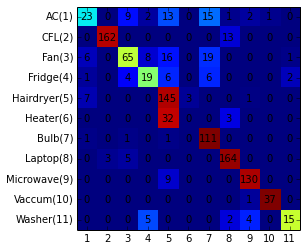

In [49]:
# draw confusion matrix

C = sklearn.metrics.confusion_matrix(trueY, predictedY[ix1[0]][ix2[0]])
conf_arr = C
norm_conf = []
for i in conf_arr:
    a = 0
    tmp_arr = []
    a = sum(i)
    for j in i:
        tmp_arr.append(float(j)/float(a))
    norm_conf.append(tmp_arr)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(norm_conf), cmap=plt.cm.jet, 
                interpolation='nearest')

width = len(conf_arr)
height = len(conf_arr[0])

for x in range(width):
    for y in range(height):
        ax.annotate(str(conf_arr[x][y]), xy=(y, x), 
                    horizontalalignment='center',
                    verticalalignment='center')

# cb = fig.colorbar(res)



# alphabet = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ'
alphabet=['AC(1)','CFL(2)','Fan(3)','Fridge(4)',
          'Hairdryer(5)','Heater(6)','Bulb(7)',
          'Laptop(8)','Microwave(9)','Vaccum(10)','Washer(11)']
xlabels=['1','2','3','4','5','6','7','8','9','10','11']
plt.xticks(range(width), xlabels[:width])
plt.yticks(range(height), alphabet[:height])
# plt.savefig('confusion_matrix.png', format='png',dpi=800)
plt.savefig('confusion_matrix.eps', format='eps')

## Downsample test

In [50]:
def downsample(X,newN):
    D = len(X)
    seg = D//newN
    newX = np.zeros([newN])
    for i in range(int(newN)):
        newX[i] = X[seg*i]
    return newX

In [51]:

m = len(Data)
n = len(Unq_loc)
num_clf = 9
width = 16
fs = 3e5
f0 = 60
# from 30k Hz to 200 Hz
new_fs = [3e4,2e4]+[i*1e3 for i in range(10,0,-1)] 
        + [i*1e2 for i in range(9,1,-1)]
# new_fs = [i*1e3 for i in range(3,0,-1)] + [i*1e2 for i in range(9,1,-1)]
n_fs = len(new_fs)
img_acc = np.empty([n_fs,num_clf])
predictedY = [[np.empty([0],dtype='int')]*num_clf]*n_fs



In [52]:
# loop over sampling frequency
start = datetime.now()

for ii in range(n_fs):
    NN = new_fs[ii]//f0
    new_Imgs = np.zeros((m,width,width), dtype=np.float64)
    # extract VI image feature for corresponding sampling frequency
    for j in range(m):
        new_V = downsample(rep_V[j,],NN)
        new_I = downsample(rep_I[j,],NN)
        new_Imgs[j,:,:] = get_img_from_VI(new_V, new_I, width,True,1)
    newBinaryF=np.reshape(new_Imgs,(m,width*width))
    print('%d/%d \t sampling frequency:%d\t  time consumed: %ds'%
          (ii+1,n_fs,new_fs[ii],(datetime.now()-start).seconds))
    # train/test for each household
    trueY = np.empty([0],dtype='int')
    for i in range(n):   
        # split data into X_train,y_train,X_test,y_test based on households
        ix_test = np.where(loc_label==i+1)[0]
        ix_train = np.where(loc_label!=i+1)[0]
        X_test = newBinaryF[ix_test]
        y_test = type_label[ix_test]
        X_train = newBinaryF[ix_train]
        y_train = type_label[ix_train]
        (_,y_p,_) = myclassifiers(X_train,y_train,X_test,y_test) 
        predictedY[ii] = [np.hstack([predictedY[ii][jj],y_p[jj]])
                          for jj in range(num_clf)]
        trueY = np.hstack([trueY,y_test])
    img_acc[ii,]= np.array([accuracy_score(trueY, jj) for jj in predictedY[ii]])
    print(max(img_acc[ii,]))


0/20 	 sampling frequency:30000.000000	  time consumed: 4s
0.800744878957
1/20 	 sampling frequency:20000.000000	  time consumed: 77s
0.829608938547
2/20 	 sampling frequency:10000.000000	  time consumed: 143s
0.819366852886
3/20 	 sampling frequency:9000.000000	  time consumed: 212s
0.827746741155
4/20 	 sampling frequency:8000.000000	  time consumed: 278s
0.823091247672
5/20 	 sampling frequency:7000.000000	  time consumed: 344s
0.826815642458
6/20 	 sampling frequency:6000.000000	  time consumed: 409s
0.805400372439
7/20 	 sampling frequency:5000.000000	  time consumed: 480s
0.798882681564
8/20 	 sampling frequency:4000.000000	  time consumed: 547s
0.821229050279
9/20 	 sampling frequency:3000.000000	  time consumed: 614s
0.780260707635
10/20 	 sampling frequency:2000.000000	  time consumed: 684s
0.758845437616
11/20 	 sampling frequency:1000.000000	  time consumed: 753s
0.788640595903
12/20 	 sampling frequency:900.000000	  time consumed: 817s
0.749534450652
13/20 	 sampling freque

/usr/local/lib/python3.4/dist-packages/sklearn/qda.py:157: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.4/dist-packages/sklearn/qda.py:157: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/usr/local/lib/python3.4/dist-packages/sklearn/qda.py:160: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


In [53]:
BinaryF.shape

(1074, 256)

In [54]:
np.set_printoptions(precision=2)
print(img_acc*100)

[[ 78.58  51.68  71.51  42.92  61.36  44.88  74.95  80.07  47.95]
 [ 82.5   61.27  76.16  40.69  76.07  47.95  76.07  82.96  28.21]
 [ 79.42  50.84  71.32  37.8   62.1   45.07  73.37  81.94  32.4 ]
 [ 82.31  65.27  74.02  35.01  72.16  47.67  74.39  82.77  36.96]
 [ 81.94  57.08  77.75  36.22  68.99  50.28  72.25  82.31  34.73]
 [ 82.12  62.29  78.03  33.24  70.48  44.04  77.    82.68  34.64]
 [ 75.42  47.58  66.2   30.35  63.22  44.23  68.72  80.54  44.88]
 [ 79.52  50.56  69.55  29.61  66.29  46.74  71.79  79.89  37.34]
 [ 78.77  60.43  70.67  26.44  68.34  44.69  70.58  82.12  31.84]
 [ 74.86  47.67  61.27  25.7   63.5   46.55  63.78  78.03  27.  ]
 [ 74.86  47.58  63.22  19.93  70.11  44.79  65.27  75.88  33.61]
 [ 78.86  49.16  69.46  20.76  73.84  45.53  64.62  78.21  32.77]
 [ 74.95  47.95  58.29  21.79  65.83  24.21  63.5   72.91  31.75]
 [ 76.82  46.65  60.43  23.37  71.04  36.78  54.56  76.26  42.27]
 [ 75.14  50.93  62.2   25.42  61.64  41.62  65.83  73.93  39.01]
 [ 75.14  

In [55]:
ix=[0,1,2,6,7]
legend_names=("kNN(1)", "GNB","LGC","DTree","RForest")
acc_plot=img_acc[:,ix]
print(legend_names)
print(acc_plot)
print(new_fs)
acc_plot

('kNN(1)', 'GNB', 'LGC', 'DTree', 'RForest')
[[ 0.79  0.52  0.72  0.75  0.8 ]
 [ 0.82  0.61  0.76  0.76  0.83]
 [ 0.79  0.51  0.71  0.73  0.82]
 [ 0.82  0.65  0.74  0.74  0.83]
 [ 0.82  0.57  0.78  0.72  0.82]
 [ 0.82  0.62  0.78  0.77  0.83]
 [ 0.75  0.48  0.66  0.69  0.81]
 [ 0.8   0.51  0.7   0.72  0.8 ]
 [ 0.79  0.6   0.71  0.71  0.82]
 [ 0.75  0.48  0.61  0.64  0.78]
 [ 0.75  0.48  0.63  0.65  0.76]
 [ 0.79  0.49  0.69  0.65  0.78]
 [ 0.75  0.48  0.58  0.64  0.73]
 [ 0.77  0.47  0.6   0.55  0.76]
 [ 0.75  0.51  0.62  0.66  0.74]
 [ 0.75  0.54  0.64  0.63  0.75]
 [ 0.75  0.57  0.67  0.62  0.75]
 [ 0.75  0.65  0.68  0.69  0.77]
 [ 0.78  0.59  0.69  0.65  0.76]
 [ 0.67  0.61  0.66  0.64  0.7 ]]
[30000.0, 20000.0, 10000.0, 9000.0, 8000.0, 7000.0, 6000.0, 5000.0, 4000.0, 3000.0, 2000.0, 1000.0, 900.0, 800.0, 700.0, 600.0, 500.0, 400.0, 300.0, 200.0]


array([[ 0.79,  0.52,  0.72,  0.75,  0.8 ],
       [ 0.82,  0.61,  0.76,  0.76,  0.83],
       [ 0.79,  0.51,  0.71,  0.73,  0.82],
       [ 0.82,  0.65,  0.74,  0.74,  0.83],
       [ 0.82,  0.57,  0.78,  0.72,  0.82],
       [ 0.82,  0.62,  0.78,  0.77,  0.83],
       [ 0.75,  0.48,  0.66,  0.69,  0.81],
       [ 0.8 ,  0.51,  0.7 ,  0.72,  0.8 ],
       [ 0.79,  0.6 ,  0.71,  0.71,  0.82],
       [ 0.75,  0.48,  0.61,  0.64,  0.78],
       [ 0.75,  0.48,  0.63,  0.65,  0.76],
       [ 0.79,  0.49,  0.69,  0.65,  0.78],
       [ 0.75,  0.48,  0.58,  0.64,  0.73],
       [ 0.77,  0.47,  0.6 ,  0.55,  0.76],
       [ 0.75,  0.51,  0.62,  0.66,  0.74],
       [ 0.75,  0.54,  0.64,  0.63,  0.75],
       [ 0.75,  0.57,  0.67,  0.62,  0.75],
       [ 0.75,  0.65,  0.68,  0.69,  0.77],
       [ 0.78,  0.59,  0.69,  0.65,  0.76],
       [ 0.67,  0.61,  0.66,  0.64,  0.7 ]])

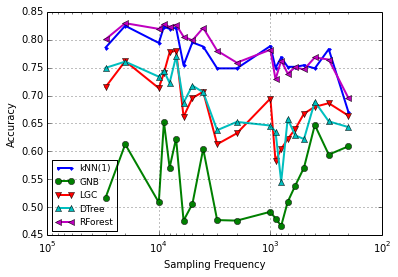

In [56]:
fig = plt.figure()
markers='.ov^<>'
colors='bgrcmk'
legend_names=("kNN(1)", "GNB","LGC","DTree","RForest")

for i in range(5):
    plt.semilogx(new_fs, acc_plot[:,i],colors[i]+markers[i]+'-',
                 label=legend_names[i],linewidth=2.0)
plt.grid(True)
plt.gca().invert_xaxis()
plt.legend(loc='lower left',prop={'size':9})
plt.xlabel('Sampling Frequency')
plt.ylabel('Accuracy')
# plt.ylim([0,1])
# plt.show()
# plt.savefig('acc_fs.eps', format='eps')